Setup the environment

In [25]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive  # Import Google Drive mounting utility
    drive.mount('/content/drive')  # Mount Google Drive

    # REPLACE WITH YOUR FOLDER

    base_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning')

    data_folder =  Path('/content')

    !pip install pytorch-lightning==2.0.9 -qq
    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq
    !pip install torchinfo

else:
    # Set base folder path for storing files on local machine
    # REPLACE WITH YOUR FOLDER
    # FILL THIS ONLY IF YOU ARE RUNNING ON A LOCAL MACHINE
    print('Path is /Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data')

    base_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning')
    data_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files')
    !pip install pytorch-lightning==2.0.9 -qq
    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
from pathlib import Path
import sys

# Determine the storage location based on the execution environment
# If running on Google Colab, use Google Drive as storage
if 'google.colab' in str(get_ipython()):
    custom_function_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files') # Your Google Drive

    sys.path.append(str(custom_function_folder))
    model_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data') # Google drive folder where you want to save model and logs
    model_folder.mkdir(parents=True, exist_ok=True)
    project_folder = model_folder
    # project_folder = Path('/content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Class/Class - 6/Imagenette_project')
    kaggle_api_folder = base_folder/'data/.kaggle'

# If running locally, specify a different path
else:
    # Set base folder path for storing files on local machine
    # REPLACE WITH YOUR FOLDER
    # FILL THIS ONLY IF YOU ARE RUNNING ON A LOCAL MACHINE
    print('Path is /Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files')
    custom_function_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Custom_files') # Your Google Drive

    sys.path.append(str(custom_function_folder))
    model_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data') # Google drive folder where you want to save model and logs
    model_folder.mkdir(parents=True, exist_ok=True)
    # project_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Class/Class - 6/Imagenette_project')
    kaggle_api_folder = base_folder/'data/.kaggle'
    # project_folder = Path('/Users/harikrishnadev/Library/CloudStorage/GoogleDrive-harikrish0607@gmail.com/My Drive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data')

In [27]:
# import Libraries
import yaml

import torch
import torch.nn as nn
import torchmetrics
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import wandb
import gc


from multiclass_lightning_module_v0 import MultiClassLightningModule
from shared_utils import  plot_losses_acc

In [28]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch
import random
from collections import defaultdict
import pytorch_lightning as pl


class TransformedSubset(Dataset):
    """
    A Dataset wrapper that applies a transform to a subset of a dataset.

    Attributes:
    subset (Dataset): The subset of data to which the transform will be applied.
    transform (callable, optional): A function/transform to apply to the images.
    """

    def __init__(self, subset, transform=None):
        self.subset = subset  # The original data subset
        self.transform = transform  # The transform function to apply on the data

    def __getitem__(self, index):
        """
        Retrieve and optionally transform the item (image, label) at the given index.

        Parameters:
        index (int): Index of the item to retrieve.

        Returns:
        tuple: Transformed image and label pair.
        """
        # Retrieve original data
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


class CIFAR10MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./cifar10", train_transform=None, test_transform=None,
                 batch_size=64, seed=42, fraction_train=0.8):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.seed = seed
        self.fraction_train = fraction_train

    def split_dataset(self, base_dataset):
        split_a_size = int(self.fraction_train * len(base_dataset))
        split_b_size = len(base_dataset) - split_a_size

        return torch.utils.data.random_split(
            base_dataset,
            [split_a_size, split_b_size],
            generator=torch.Generator().manual_seed(self.seed)
        )

    def prepare_data(self):
        # download
        datasets.CIFAR10(self.data_dir, train=True, download=True)
        datasets.CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage: str):
        self.testset = datasets.CIFAR10(
            self.data_dir, transform=self.test_transform, train=False , download=True
        )
        self.predictset = datasets.CIFAR10(
            self.data_dir, transform=self.test_transform, train=False, download=True
        )
        self.train_val_set = datasets.CIFAR10(
            self.data_dir, train=True , download=True
        )
        self.trainset, self.validset = self.split_dataset(self.train_val_set)
        self.trainset_transformed = TransformedSubset(self.trainset, self.train_transform)
        self.validset_transformed = TransformedSubset(self.validset, self.test_transform)

    def train_dataloader(self):
        return DataLoader(
            self.trainset_transformed, batch_size=self.batch_size, shuffle=True, drop_last=True
        )

    def val_dataloader(self):
        return DataLoader(self.validset_transformed, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.predictset, batch_size=self.batch_size, shuffle=False)


def get_stratified_subset(dataset, num_samples, seed=None):
    if seed is not None:
        random.seed(seed)

    # Step 1: Identify label distribution
    label_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        label_to_indices[label].append(idx)

    # Step 2: Calculate proportions and initialize subset indices list
    proportions = {label: len(indices) / len(dataset) for label, indices in label_to_indices.items()}
    subset_indices = []

    # Step 3: Sample according to proportion
    for label, indices in label_to_indices.items():
        num_samples_for_label = round(proportions[label] * num_samples)
        subset_indices += random.sample(indices, num_samples_for_label)

    # Step 4: Combine samples
    return torch.utils.data.Subset(dataset, subset_indices)

In [29]:
dm = CIFAR10MNISTDataModule()
dm.prepare_data()

Files already downloaded and verified
Files already downloaded and verified


In [30]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [31]:
dm.setup('fit')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [32]:
import torchvision.models as models
def load_model(config):
    model = models.__dict__[config['model_name']](pretrained=config['pretrained'])

    for param in model.parameters():
        param.requires_grad = False

    for i, requires_grad in enumerate(config['classifier']):
        if requires_grad:
            model.classifier[i].requires_grad_(True)

    if config['out_features'] != model.classifier[6].out_features:
        model.classifier[6] = nn.Linear(in_features=model.classifier[6].in_features, out_features=config['out_features'], bias=True)

    return model

In [33]:
def load_datamodule(config,data_folder):
    # Fetch the correct transform function based on config and pass the appropriate arguments
    dm = CIFAR10MNISTDataModule(
        data_dir=data_folder,
        train_transform=train_transform,
        test_transform=test_transform,
        **config['data_module']
    )
    return dm

In [34]:
def load_lightning_module(config, model):
    optimizer_cls = eval(config['optimizer_cls'])
    loss_fn = eval(config['loss_fn'])()  # directly instantiate the loss function
    metric_cls = eval(config['metric_cls'])

    # If scheduler is defined, convert its string to class as well
    if config.get('scheduler_cls'):
        scheduler_cls = eval(config['scheduler_cls'])
        scheduler_options = config['scheduler_options']
        scheduler_params =   config['scheduler_params']
    else:
        scheduler_cls = None

    lightning_module = MultiClassLightningModule(model=model,
                                                 optimizer_cls=optimizer_cls,
                                                 loss_fn=loss_fn,
                                                 metric_cls=metric_cls,
                                                 scheduler_cls=scheduler_cls,
                                                 scheduler_options=scheduler_options,
                                                 scheduler_params=scheduler_params,
                                                 **config['others']
)
    return lightning_module

In [35]:
def load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=False, checkpointing=True, early_stopping=False):

    lr_monitor = LearningRateMonitor(**cl_config['lr_monitor'])
    callbacks = [lr_monitor]
    if checkpointing:
        model_checkpoint_callback = ModelCheckpoint(dirpath=model_folder/cl_config['log_dir'],
                                                **cl_config['model_checkpoint'])
        callbacks.append(model_checkpoint_callback)

    if early_stopping:
        early_stop_callback = EarlyStopping(**cl_config['early_stopping'] )
        callbacks.append(early_stop_callback)

    if logging:
        # For WandB logger:
        wandb_logger = WandbLogger(project=cl_config['wandb']['project'], name=cl_config['wandb']['name'], save_dir=model_folder/cl_config['log_dir'])
        wandb_logger.experiment.config.update({'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})
        wandb_logger.watch(model)

        # For CSV logger:
        csv_logger = CSVLogger(save_dir=model_folder/cl_config['log_dir'], name=cl_config['csv']['name'])
        csv_logger.log_hyperparams(params={'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})

        trainer = pl.Trainer(callbacks=callbacks,
                            logger=[csv_logger, wandb_logger],
                            **trainer_config)
    else:
        trainer = pl.Trainer(callbacks=callbacks,
                            **trainer_config
                )
    return trainer

In [36]:
def load_components(model_config, data_module_config, lightning_module_config, data_folder, trainer_config,
cl_config, batch_size,logging=False, checkpointing=True, early_stopping=False):

    # Load the model
    model = load_model(model_config)

    # Load the data module
    dm = load_datamodule(data_module_config, data_folder)

    # Load the lightning module
    lightning_module = load_lightning_module(lightning_module_config, model)

    # Load the trainer
    trainer = load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=logging,
                           checkpointing=checkpointing, early_stopping=early_stopping)

    return model, dm, lightning_module, trainer

In [37]:
def load_yaml(filepath):
    with open(filepath, 'r') as file:
        return yaml.safe_load(file)

In [38]:
project_folder = custom_function_folder

In [39]:
# Load configurations from YAML files
def load_all_configs():
    model_config = load_yaml(project_folder/'model_config_cifar10.yaml')
    data_module_config = load_yaml(project_folder/'data_module_cifar10.yaml')
    lightning_module_config = load_yaml(project_folder/'lightning_module_config.yaml')
    cl_config = load_yaml(project_folder/'callbacks_loggers_config_fminst.yaml')
    trainer_config = load_yaml(project_folder/'trainer_config.yaml')
    return model_config, data_module_config, lightning_module_config, cl_config, trainer_config

In [40]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

In [41]:
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
model_config

{'model_name': 'vgg16',
 'pretrained': True,
 'hidden_size': 4096,
 'out_features': 10,
 'classifier': [{'requires_grad': True},
  {'requires_grad': False},
  {'requires_grad': False},
  {'requires_grad': True},
  {'requires_grad': False},
  {'requires_grad': False},
  {'last_layer': {'type': 'linear',
    'in_features': 4096,
    'out_features': 10,
    'bias': True}}]}

In [42]:
data_module_config

{'data_module': {'batch_size': 64, 'seed': 42}}

In [43]:
def count_parameters(model):
  """
  Function to count the number of trainable parameters in the model
  Input: model
  Output: Number of trainable parameters in the input model
  """
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters in the model
print(count_parameters(load_model(model_config)))

119586826


In [44]:
load_model(model_config)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1: Val_Loss: 2.35, Val_Metric: 0.11 | 

Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: Val_Loss: 33.10, Val_Metric: 0.12 | 

INFO:pytorch_lightning.tuner.lr_finder:LR finder stopped early after 19 steps due to diverging loss.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.0006812920690579612
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_abaca638-d180-4b28-88f2-ac477eff814b.ckpt


Train_Loss: 4.82, Train_Metric: 0.21


INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_abaca638-d180-4b28-88f2-ac477eff814b.ckpt


0.0006812920690579612


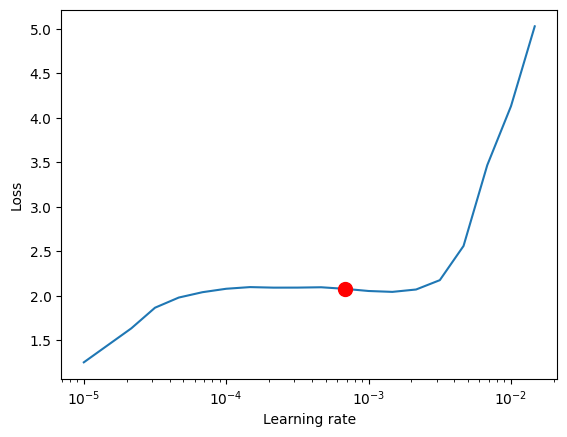

In [45]:
# Load components
from pytorch_lightning.tuner import Tuner
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['max_epochs']=5
data_module_config['data_module']['batch_size']=64

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config,batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup('fit')
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)

In [46]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['fast_dev_run']=True
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
119 M     Trainable params
14.7 M    Non-trainable params
134 M     Total params
537.206   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.14 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


Train_Loss: 2.35, Train_Metric: 0.17


INFO:lightning_fabric.utilities.seed:Global seed set to 42
wandb: Currently logged in as: harikrish0607 (harikrishnad). Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/optimizer.py:289: RuntimeWarning: A `OneCycleLR` scheduler is using 'interval': 'epoch'. Are you sure you didn't mean 'interval': 'step'?
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
119 M     Trainable params
14.7 M    Non-trainable params
134 M     Total params
537.206   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.32, Val_Metric: 0.15 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 1.32, Val_Metric: 0.53 | Train_Loss: 1.51, Train_Metric: 0.46


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 1.27, Val_Metric: 0.55 | Train_Loss: 1.34, Train_Metric: 0.52


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 1.24, Val_Metric: 0.56 | Train_Loss: 1.29, Train_Metric: 0.54


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 1.19, Val_Metric: 0.58 | Train_Loss: 1.26, Train_Metric: 0.55


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 1.22, Val_Metric: 0.57 | Train_Loss: 1.24, Train_Metric: 0.56


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


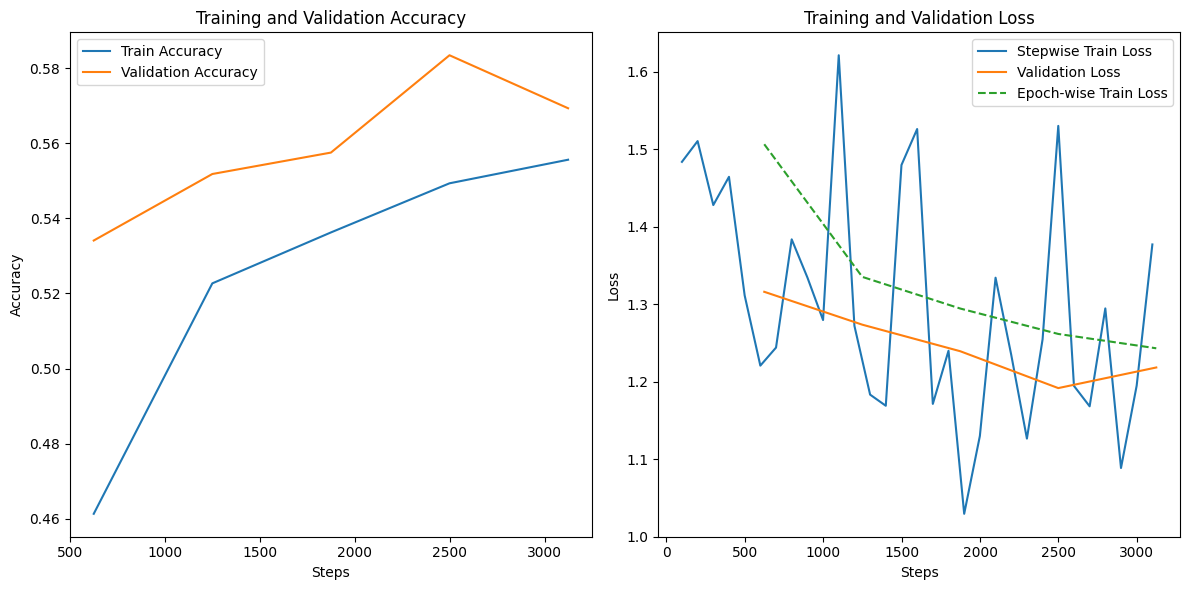

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_51/checkpoints/epoch=4-step=3125.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_51/checkpoints/epoch=4-step=3125.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a 

Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 1.18, Val_Metric: 0.58 | Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_51/checkpoints/epoch=4-step=3125.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Colab_Notebooks/BUAN_6382_Applied_DeepLearning/Data/logs/csvlogger/version_51/checkpoints/epoch=4-step=3125.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 1.22, Val_Metric: 0.57 | Train Accuracy: 57.70
Validation Accuracy: 56.93


epoch,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█
lr-AdamW,▁▁▃▅█
train_loss_epoch,█▃▂▁▁
train_loss_step,▆▇▆▆▄▃▄▅▅▄█▄▃▃▆▇▃▃▁▂▅▃▂▄▇▃▃▄▂▃▅
train_metric,▁▆▇██
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
val_loss,█▆▄▂▃▁▃
val_metric,▁▄▄█▆▇▆
epoch,5
lr-AdamW,4e-05
train_loss_epoch,1.24314


In [47]:
# Load components

free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values

trainer_config['max_epochs']=5
trainer_config['gradient_clip_val']=1
trainer_config['log_every_n_steps']=100

# lightning module config
lightning_module_config['others']['optimizer_params']['weight_decay']= 1
lightning_module_config['others']['learning_rate']=0.001

# Setting the scheduler class
lightning_module_config['scheduler_cls'] = 'torch.optim.lr_scheduler.OneCycleLR'

# Parameters for the OneCycleLR
# Note: 'max_lr' is a required parameter for OneCycleLR; you'll need to specify it based on your needs
lightning_module_config['scheduler_params'] = {'max_lr':1e-3,'steps_per_epoch':75, 'final_div_factor': 1e4, 'div_factor': 25.0, 'pct_start':0.3, 'anneal_strategy':'cos','epochs':4}

# Options related to the monitoring of the scheduler (if needed)
lightning_module_config['scheduler_options'] = {'monitor': 'val_loss', 'interval': 'epoch', 'frequency': 1}

# logging
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='imagenette2_multiclass_CNN'
cl_config['wandb']['name']='simple_cnn_exp1'

# Data Module
data_module_config['data_module']['batch_size']=64
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=False, early_stopping=False)
dm.setup('fit')
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
wandb.finish()